<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/fix_folder_names/tutorials/W1D3_MultiLayerPerceptrons/W1D3_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Neuromatch Academy: Week 1, Day 3, Tutorial 2
# Multi-layer Perceptrons

__Content creators:__ Arash Ash



__Content reviewers:__ Saeed Salehi, Felix Bartsch, Yu-Fang Yang. 

__Content editors:__ Gagana B, Spiros Chavlis.

__Production editors:__ Anoop Kulkarni, Spiros Chavlis.

---
# Tutorial Objectives
In the second tutorial of Week 3, we will dive deeper into MLPs and see more of their mathematical and practical aspects. Today we are going to see why MLPs:

* can evolve linearly in weights 
* the case of deep vs. wide
* dependant on transfer functions
* sensitive to initialization

In [1]:
#@markdown Tutorial slides
# you should link the slides for all tutorial videos here (we will store pdfs on osf)

from IPython.display import HTML
HTML('<iframe src="https://docs.google.com/presentation/d/e/2PACX-1vSPvHqDTmMq4GyQy6lieNEFxq4qz1SmqC2RNoeei3_niECH53zneh8jJVYOnBIdk0Uaz7y2b9DK8V1t/embed?start=false&loop=false&delayms=3000" frameborder="0" width="960" height="569" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>')

---
# Setup

In [2]:
# @title Imports
import random
import pathlib
import random, time

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
from IPython.display import HTML, display

dev = "cpu"

In [3]:
# @title Seeding for reproducibility
seed = 522
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
def seed_worker(worker_id):
    worker_seed = seed % (worker_id+1)
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [4]:
# @title Dataset download
%%capture
!rm -r AnimalFaces32x32/
!git clone https://github.com/arashash/AnimalFaces32x32
!rm -r afhq/
!unzip ./AnimalFaces32x32/afhq_32x32.zip

In [5]:
# @title Figure Settings
import ipywidgets as widgets
%matplotlib inline
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'
my_layout = widgets.Layout()

In [6]:
# @title Helper functions
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis(False)
    plt.show()

def color_grad(grad, M=500, x_max=1):
  """Plot gradient

  """
  grad = grad.detach().cpu()
  grad_colors = grad[:, 0]
  grad_colors = (grad_colors / grad_colors.max() * 1e3).int() % 10
  grad_colors = grad_colors.view(M, M).cpu().numpy()
  return grad_colors

def progress(epoch, loss, epochs=100):
    return HTML("""
        <label for="file">Training loss: {loss}</label>
        <progress
            value='{epoch}'
            max='{epochs}',
            style='width: 100%'
        >
            {epoch}
        </progress>
    """.format(loss=loss, epoch=epoch, epochs=epochs))

In [7]:
# @title Part 1 Code
class Net(nn.Module):
    def __init__(self, actv, num_inputs, hidden_units, num_outputs):
        super(Net, self).__init__()

        exec('self.actv = nn.%s'%actv)

        self.layers = nn.ModuleList()
        for i in range(len(hidden_units)):
          next_num_inputs = hidden_units[i]
          self.layers += [nn.Linear(num_inputs, next_num_inputs)]
          num_inputs = next_num_inputs

        self.out = nn.Linear(num_inputs, num_outputs)

    def forward(self, x):
        # flattening
        x = x.view(x.shape[0], -1)

        for layer in self.layers:
          x = self.actv(layer(x))
        x = self.out(x)
        return x

K = 4
sigma = 0.4
N = 1000
t = torch.linspace(0, 1, N)
X = torch.zeros(K*N, 2)
y = torch.zeros(K*N)
for k in range(K):
  X[k*N:(k+1)*N, 0] = t*(torch.sin(2*np.pi/K*(2*t+k)) + sigma**2*torch.randn(N))   # [TO-DO]
  X[k*N:(k+1)*N, 1] = t*(torch.cos(2*np.pi/K*(2*t+k)) + sigma**2*torch.randn(N))   # [TO-DO]
  y[k*N:(k+1)*N] = k

# Shuffling
shuffled_indeces = torch.randperm(K*N)
X = X[shuffled_indeces]
y = y[shuffled_indeces]

# Test Train splitting
test_size = int(0.2*N)
X_test = X[:test_size]
y_test = y[:test_size]
X_train = X[test_size:]
y_train = y[test_size:]


batch_size = 128
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=0)

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True,
                        shuffle=True, num_workers=0, worker_init_fn=seed_worker)

def train_test_classification(net, criterion, optimizer,
                              train_loader, test_loader,
                              num_epochs=1, verbose=True,
                              training_plot=False):
  if verbose:
    progress_bar = display(progress(0, 0, num_epochs), display_id=True)

  net.train()
  training_losses = []
  for epoch in range(num_epochs):  # loop over the dataset multiple times
      running_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.to(dev).float()
          labels = labels.to(dev).long()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          if verbose:
            training_losses += [loss.item()]
            running_loss += loss.item()
            if i % 10 == 9:    # update every 10 mini-batches
                progress_bar.update(progress(epoch+1, running_loss / 10, num_epochs))
                running_loss = 0.0

  net.eval()
  def test(data_loader):
    correct = 0
    total = 0
    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(dev).float()
        labels = labels.to(dev).long()

        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return total, acc

  train_total, train_acc = test(train_loader)
  test_total, test_acc = test(test_loader)

  if verbose:
    print('Accuracy on the %d training samples: %0.2f %%' % (train_total, train_acc))
    print('Accuracy on the %d testing samples: %0.2f %%' % (test_total, test_acc))

  if training_plot:
    plt.plot(training_losses)
    plt.xlabel('Batch')
    plt.ylabel('Training loss')
    plt.show()

  return train_acc, test_acc

def sample_grid(M=500, x_max = 2.0):
  ii, jj = torch.meshgrid(torch.linspace(-x_max, x_max,M),
                          torch.linspace(-x_max, x_max, M))
  X_all = torch.cat([ii.unsqueeze(-1),
                     jj.unsqueeze(-1)],
                     dim=-1).view(-1, 2)
  return X_all

def plot_decision_map(X_all, y_pred, X_test, y_test, M=500, x_max = 2.0, eps = 1e-3):
  decision_map = torch.argmax(y_pred, dim=1)

  for i in range(len(X_test)):
    indeces = (X_all[:, 0] - X_test[i, 0])**2 + (X_all[:, 1] - X_test[i, 1])**2 < eps    # [TO-DO]
    decision_map[indeces] = (K + y_test[i]).long()

  decision_map = decision_map.view(M, M).cpu()
  plt.imshow(decision_map, extent=[-x_max, x_max, -x_max, x_max], cmap='jet')
  plt.plot()

---
# Section 1: Wider vs deeper networks

Video available at https://youtu.be/5AxFjPZGuTc


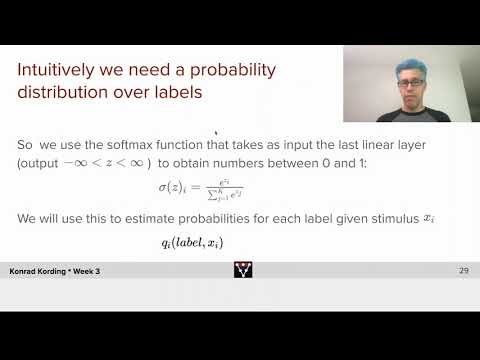

In [8]:
#@title Video 1: Cross Entropy
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="5AxFjPZGuTc", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Video available at https://youtu.be/H18gs1z2PTw


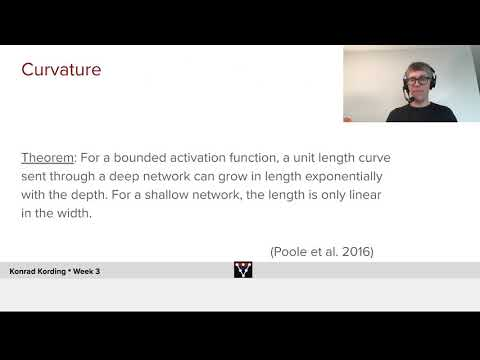

In [9]:
#@title Video 2: Expressivity vs Learnability
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="H18gs1z2PTw", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## Exercise 1: Wide vs. Deep while keeping number of parameters same
Let's find the optimal number of hidden layers under a fixed number of parameters constraint!

But first, we need a model parameter counter. You could iterate over the model layers by calling `.parameters()` and then use `.numel()` to count the layer parameters. Also, you can use `requires_grad` attribute to make sure it's a trainable parameter.

After defining the counter function, we will step by step increase the depth and then iterate over the possible number of hidden units (assuming same for all hidden layers); then using our parameter counter choose the number of hidden units that results in overall close to `max_par_count` parameters.

In [10]:
def run_depth_optimizer(max_par_count,  max_hidden_layer):
  ####################################################################
  # Fill in all missing code below (...),
  # then remove or comment the line below to test your function
  raise NotImplementedError("Define the depth optimizer function")
  ###################################################################

  def count_parameters(model):
    par_count = 0
    for p in model.parameters():
      if p.requires_grad:
        par_count += ...
    return par_count

  # number of hidden layers to try
  hidden_layers = ...

  # test test score list
  test_scores = []

  for hidden_layer in hidden_layers:
    # Initialize the hidden units in each hidden layer to be 1
    hidden_units = np.ones(hidden_layer, dtype=np.int)

    # Define the the with hidden units equal to 1
    wide_net = Net('ReLU()', X_train.shape[1], hidden_units, K).to(dev)
    par_count = count_parameters(wide_net)

    # increment hidden_units and repeat until the par_count reaches the desired count
    while par_count < max_par_count:
      hidden_units += 1
      wide_net = Net('ReLU()', X_train.shape[1], hidden_units, K).to(dev)
      par_count = ...

    # Train it
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(wide_net.parameters(), lr=1e-3)
    _, test_acc = train_test_classification(wide_net, criterion, optimizer, train_loader,
                                            test_loader, num_epochs=100)
    test_scores += [test_acc]

  return hidden_layers, test_scores

### Uncomment below to test your function
#max_par_count = 100
#max_hidden_layer = 5
#hidden_layers, test_scores = run_depth_optimizer(max_par_count,  max_hidden_layer)

#with plt.xkcd():
#  plt.xlabel('# of hidden layers')
#  plt.ylabel('Test accuracy')
#  plt.plot(hidden_layers, test_scores)
#  plt.show()

Accuracy on the 3712 training samples: 75.81 %
Accuracy on the 200 testing samples: 78.00 %


Accuracy on the 3712 training samples: 84.35 %
Accuracy on the 200 testing samples: 82.50 %


Accuracy on the 3712 training samples: 94.13 %
Accuracy on the 200 testing samples: 95.00 %


Accuracy on the 3712 training samples: 94.56 %
Accuracy on the 200 testing samples: 96.50 %


Accuracy on the 3712 training samples: 70.64 %
Accuracy on the 200 testing samples: 72.50 %


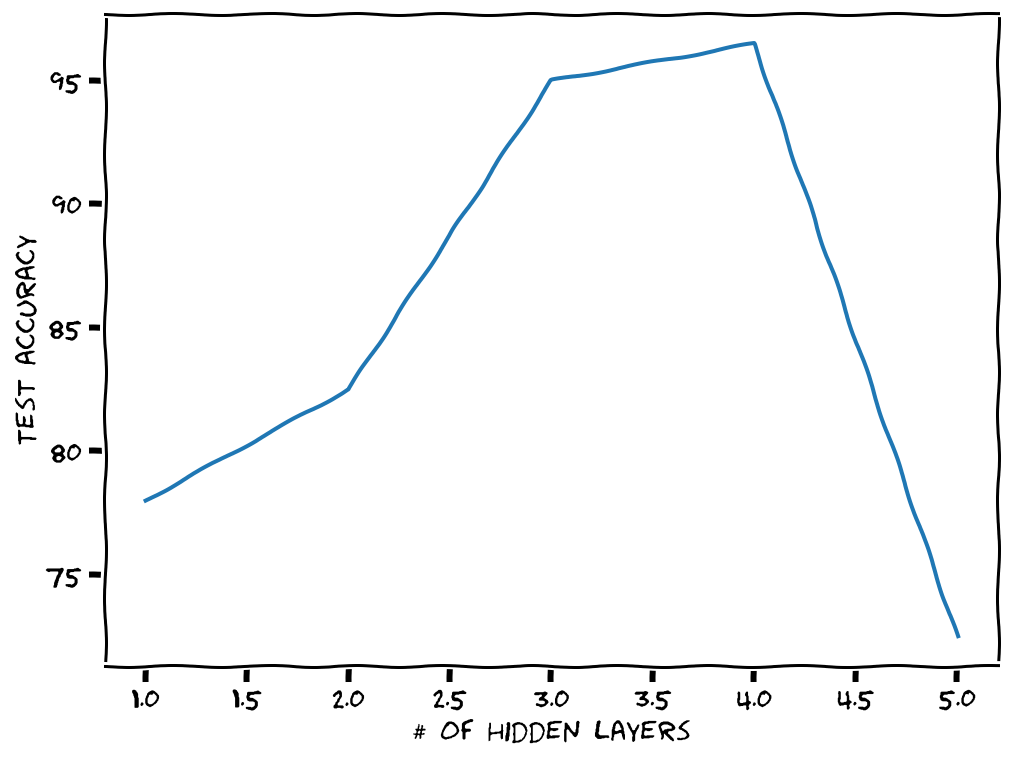

In [11]:
# to_remove solution
def run_depth_optimizer(max_par_count,  max_hidden_layer):

  def count_parameters(model):
    par_count = 0
    for p in model.parameters():
      if p.requires_grad:
        par_count += p.numel()
    return par_count

  # number of hidden layers to try
  hidden_layers = range(1, max_hidden_layer+1)

  # test test score list
  test_scores = []

  for hidden_layer in hidden_layers:
    # Initialize the hidden units in each hidden layer to be 1
    hidden_units = np.ones(hidden_layer, dtype=np.int)

    # Define the the with hidden units equal to 1
    wide_net = Net('ReLU()', X_train.shape[1], hidden_units, K).to(dev)
    par_count = count_parameters(wide_net)

    # increment hidden_units and repeat until the par_count reaches the desired count
    while par_count < max_par_count:
      hidden_units += 1
      wide_net = Net('ReLU()', X_train.shape[1], hidden_units, K).to(dev)
      par_count = count_parameters(wide_net)

    # Train it
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(wide_net.parameters(), lr=1e-3)
    _, test_acc = train_test_classification(wide_net, criterion, optimizer, train_loader,
                                            test_loader, num_epochs=100)
    test_scores += [test_acc]

  return hidden_layers, test_scores

### Uncomment below to test your function
max_par_count = 100
max_hidden_layer = 5
hidden_layers, test_scores = run_depth_optimizer(max_par_count,  max_hidden_layer)

with plt.xkcd():
  plt.xlabel('# of hidden layers')
  plt.ylabel('Test accuracy')
  plt.plot(hidden_layers, test_scores)
  plt.show()

In [12]:
#@markdown Here we see that there is a particular number of hidden layers that is optimum. Why do you think increasing hidden layers after a certain point hurt in this scenario?
w3_why_three = '' #@param {type:"string"}

## Section 1.1: Where Wide Fails
Let's use the same Spiral dataset generated before with two features. And then add more polynomial features (which makes the first layer wider). And finally, train a single Linear layer. We could use the same MLP network with no hidden layers (though it would not be called an MLP anymore!).

Note that we will add polynomial terms upto $P=50$ which means that for every $x_1^n x_2^m$ term, $n+m\leq P$. Now it's fun math excercise to prove why the total number of polynomial features upto $P$ becomes,
$$
\text{# of terms} = \frac{(P+1)(P+2)}{2}
$$

Also, we don't need the polynomial term with degree zero (which is the constatnt term) since `nn.Linear` layers have bias terms. Therefore we will have one fewer polynomial feature.

Accuracy on the 3800 training samples: 72.26 %
Accuracy on the 200 testing samples: 74.00 %


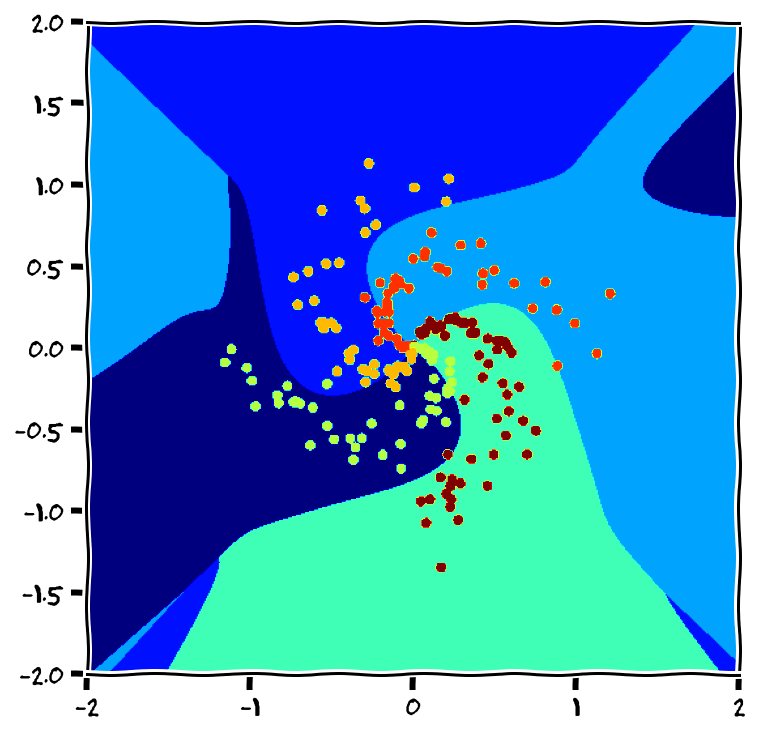

Number of features: 1325


In [13]:
def run_poly_clasification(poly_degree):

  def make_poly_features(poly_degree, X):
    # Define the number of polynomial features except the bias term
    num_features = (poly_degree+1)*(poly_degree+2)//2-1
    poly_X = torch.zeros((X.shape[0], num_features))
    count = 0
    for i in range(poly_degree+1):
      for j in range(poly_degree+1):
         # no need to add zero degree since model has biases
        if j+i > 0:
          if j+i <= poly_degree:
            # Define the polynomial term
            poly_X[:, count] = X[:, 0]**i * X[:, 1]**j
            count += 1
    return poly_X, num_features

  poly_X_test, num_features = make_poly_features(poly_degree, X_test)
  poly_X_train, _ = make_poly_features(poly_degree, X_train)

  batch_size = 128
  poly_test_data = TensorDataset(poly_X_test, y_test)
  poly_test_loader = DataLoader(poly_test_data, batch_size=batch_size,
                          shuffle=False, num_workers=1)
  poly_train_data = TensorDataset(poly_X_train, y_train)
  poly_train_loader = DataLoader(poly_train_data, batch_size=batch_size,
                          shuffle=True, num_workers=1)

  # define a linear model using MLP class
  poly_net = Net('ReLU()', num_features, [], K).to(dev)

  # Train it!
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(poly_net.parameters(), lr=1e-3)
  _, _ = train_test_classification(poly_net, criterion, optimizer,
                                  poly_train_loader, poly_test_loader,
                                  num_epochs=100)
  # Test it
  X_all = sample_grid().to(dev)
  poly_X_all, _ = make_poly_features(poly_degree, X_all)
  y_pred = poly_net(poly_X_all.to(dev))

  # Plot it
  with plt.xkcd():
    plot_decision_map(X_all, y_pred, X_test, y_test)
    plt.show()

  return num_features

### Uncomment below to test your function
max_poly_degree = 50
num_features = run_poly_clasification(max_poly_degree)
print('Number of features: %d'%num_features)

In [14]:
#@markdown Do you think this model is performing well outside its training distribution? Why?
w3_poly_OoD = '' #@param {type:"string"}

---
# Section 2: Linear Learning in Wide Multi-Layer Perceptrons (Advanced)
Feel free to skip if you just want applications!

Video available at https://youtu.be/5Lj6kp4k7Sk


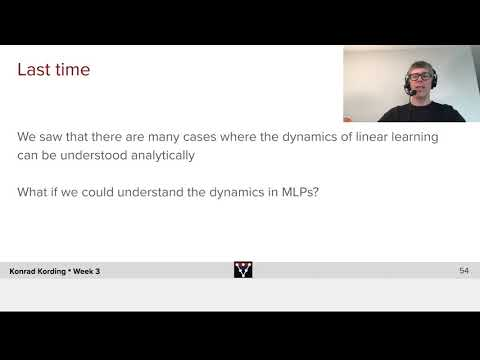

In [15]:
#@title Video 3: Neural Tngent Kernels
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="5Lj6kp4k7Sk", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## Exercise 2: Motivation for Neural Tangent Kernels (NTKs)
lazy training of overcomplete MLPs results in linear changes in weights. Let's try to see it here.

We will train a wide MLP step by step with small learning rates (when the learning rate is low, it's called lazy or linear training!) and keep track of some of the weight to see how they change.

Note that you could index the network layers like a list (since we defined it with ModuleList). You could access the weights and biases of a `nn.Linear` layer by getting `.weight` and `.bias` attributes.

In [16]:
def run_lazy_training(num_time_steps, num_select_weights, step_epoch):
  ####################################################################
  # Fill in all missing code below (...),
  # then remove or comment the line below to test your function
  raise NotImplementedError("Define the lazy training function")
  ###################################################################

  # Define a wide MLP
  net = ...
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=1e-2)

  # let's save only couple of parameters at each time step
  weights = torch.zeros(num_time_steps, num_select_weights)
  for i in range(num_time_steps):
    _, _ = train_test_classification(net, criterion, optimizer, train_loader,
                                    test_loader, num_epochs=step_epoch, verbose=False)

    # let's pratice some tensor navigations!
    # access the first layer weights
    # and index the first column
    # and slice upto num_select_weights paramaeters
    weights[i] = ...

  return weights

### Uncomment below to test your function
#num_select_weights = 10
#num_time_steps = 5
#step_epoch = 50
#weights = run_lazy_training(num_time_steps, num_select_weights, step_epoch)
#with plt.xkcd():
#  for k in range(num_select_weights):
#    weight = weights[:, k].detach()
#    epochs = range(1, 1+num_time_steps*step_epoch, step_epoch)
#    plt.plot(epochs, weight, label='weight #%d'%k)

#  plt.xlabel('epochs')
#  plt.legend()
#  plt.show()

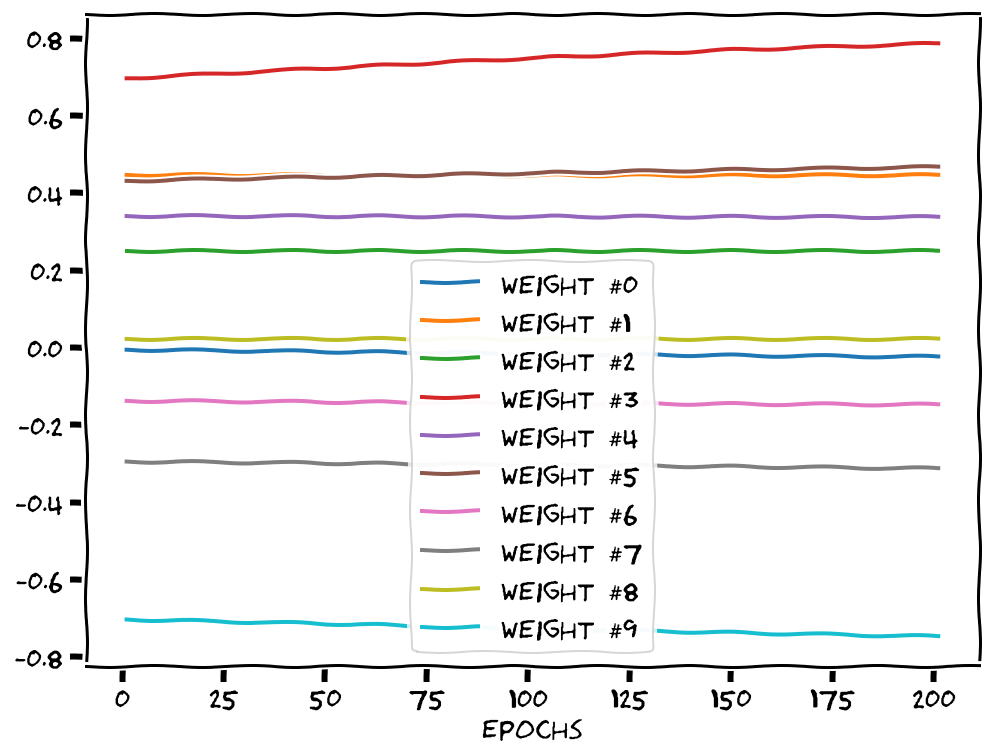

In [17]:
# to_remove solution
def run_lazy_training(num_time_steps, num_select_weights, step_epoch):

  # Define a wide MLP
  net = Net('ReLU()', X_train.shape[1], [1000], K).to(dev)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=1e-2)

  # let's save only couple of parameters at each time step
  weights = torch.zeros(num_time_steps, num_select_weights)
  for i in range(num_time_steps):
    _, _ = train_test_classification(net, criterion, optimizer, train_loader,
                                    test_loader, num_epochs=step_epoch, verbose=False)

    # let's pratice some tensor navigations!
    # access the first layer weights
    # and index the first column
    # and slice upto num_select_weights paramaeters
    weights[i] = net.layers[0].weight[:num_select_weights, 0]

  return weights

### Uncomment below to test your function
num_select_weights = 10
num_time_steps = 5
step_epoch = 50
weights = run_lazy_training(num_time_steps, num_select_weights, step_epoch)
with plt.xkcd():
  for k in range(num_select_weights):
    weight = weights[:, k].detach()
    epochs = range(1, 1+num_time_steps*step_epoch, step_epoch)
    plt.plot(epochs, weight, label='weight #%d'%k)

  plt.xlabel('epochs')
  plt.legend()
  plt.show()

## Section 2.1: Neural Tangent Kernels (NTKs)

Video available at https://youtu.be/rjbpZCSuMgQ


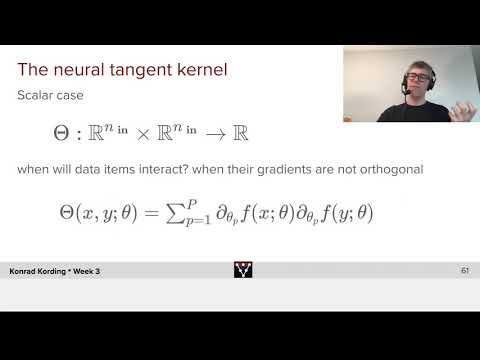

In [18]:
#@title Video 2.1: Neural Tangent Kernels
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="rjbpZCSuMgQ", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

In [19]:
#@markdown How could we speed up lazy training?
w3_fast_NTK = '' #@param {type:"string"}

---
# Section 3: Deeper MLPs

Video available at https://youtu.be/RtcJ8gn2kj0


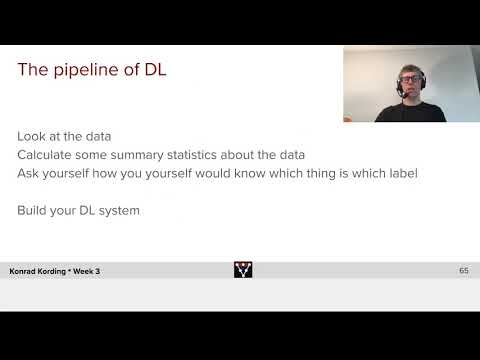

In [20]:
#@title Video 3: Data Augmentation
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="RtcJ8gn2kj0", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## Exercise 3: Dataloader on a real-world dataset
Let's build our first real-world dataset loader with Data Preprocessing and Augmentation! And we will use the Torchvision transforms to do it.

We'd like to have a simple data augmentation with the following steps:
* Random rotation with 10 degrees (RandomRotation)
* Random horizontal flipping (RandomHorizontalFlip)

and we'd like a preprocessing that:
* makes Pytorch tensors in the range [0, 1] (ToTensor)
* normalizes the input in the range [-1, 1] (Normalize)

In [21]:
def get_data_loaders(batch_size):
  ####################################################################
  # Fill in all missing code below (...),
  # then remove or comment the line below to test your function
  raise NotImplementedError("Define the get data loaders function")
  ###################################################################

  # define the transform done only during training
  augmentation_transforms = ...

  # define the transform done in training and testing (after augmentation)
  preprocessing_transforms = ...

  # compose them together
  train_transform = transforms.Compose(augmentation_transforms + preprocessing_transforms)
  test_transform = transforms.Compose(preprocessing_transforms)

  # using pathlib to be compatible with all OS's
  data_path = pathlib.Path('.')/'afhq'

  # define the dataset objects (they can load one by one)
  img_train_dataset = ImageFolder(data_path/'train', transform=train_transform)
  img_test_dataset = ImageFolder(data_path/'val', transform=test_transform)

  # define the dataloader objects (they can load batch by batch)
  img_train_loader = DataLoader(img_train_dataset, batch_size=batch_size,
                                shuffle=True, num_workers=1, worker_init_fn=seed_worker)
  # num_workers can be set to higher if running on Colab Pro TPUs to speed up,
  # with more than one worker, it will do multithreading to queue batches
  img_test_loader = DataLoader(img_test_dataset, batch_size=batch_size,
                          shuffle=False, num_workers=1)

  return img_train_loader, img_test_loader

### Uncomment below to test your function
#batch_size = 64
#img_train_loader, img_test_loader = get_data_loaders(batch_size)
## get some random training images
#dataiter = iter(img_train_loader)
#images, labels = dataiter.next()
## show images
#imshow(make_grid(images, nrow=8))

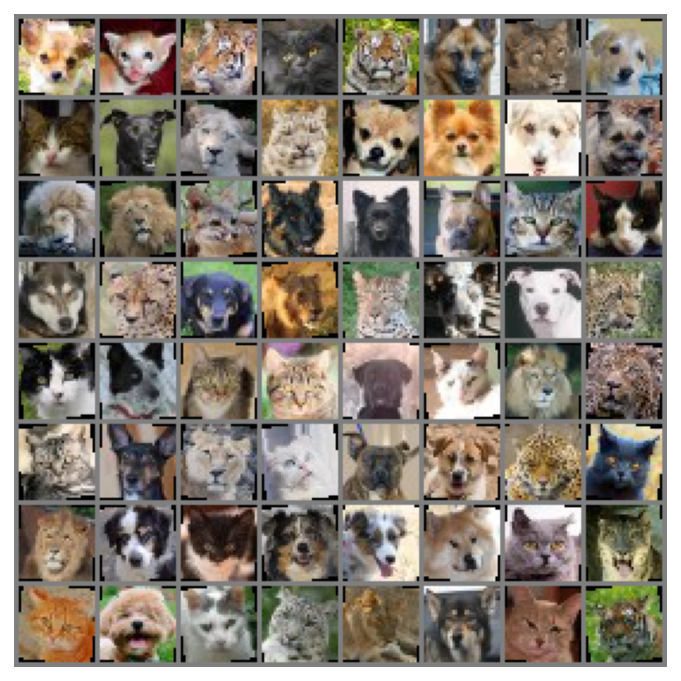

In [22]:
# to_remove solution
def get_data_loaders(batch_size):
  # define the transform done only during training
  augmentation_transforms = [transforms.RandomRotation(10), transforms.RandomHorizontalFlip()]

  # define the transform done in training and testing (after augmentation)
  preprocessing_transforms = [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

  # compose them together
  train_transform = transforms.Compose(augmentation_transforms + preprocessing_transforms)
  test_transform = transforms.Compose(preprocessing_transforms)

  # using pathlib to be compatible with all OS's
  data_path = pathlib.Path('.')/'afhq'

  # define the dataset objects (they can load one by one)
  img_train_dataset = ImageFolder(data_path/'train', transform=train_transform)
  img_test_dataset = ImageFolder(data_path/'val', transform=test_transform)

  # define the dataloader objects (they can load batch by batch)
  img_train_loader = DataLoader(img_train_dataset, batch_size=batch_size,
                                shuffle=True, num_workers=1, worker_init_fn=seed_worker)
  # num_workers can be set to higher if running on Colab Pro TPUs to speed up,
  # with more than one worker, it will do multithreading to queue batches
  img_test_loader = DataLoader(img_test_dataset, batch_size=batch_size,
                          shuffle=False, num_workers=1)

  return img_train_loader, img_test_loader

### Uncomment below to test your function
batch_size = 64
img_train_loader, img_test_loader = get_data_loaders(batch_size)
# get some random training images
dataiter = iter(img_train_loader)
images, labels = dataiter.next()
# show images
imshow(make_grid(images, nrow=8))

Video available at https://youtu.be/JHJQZCD0mhA


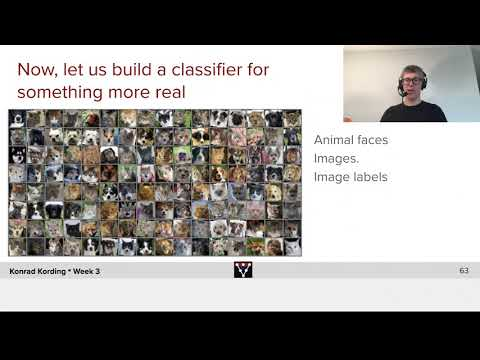

In [23]:
#@title Video 3.1: Classifying Animal Faces
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="JHJQZCD0mhA", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

In [24]:
# Train it
net = Net('ReLU()', 3*32*32, [64, 64, 64], 3).to(dev)
criterion = nn.MultiMarginLoss(margin=1.0)
optimizer = optim.Adam(net.parameters(), lr=3e-4)
_, _ = train_test_classification(net, criterion, optimizer,
                                img_train_loader, img_test_loader,
                                num_epochs=30)

Accuracy on the 14630 training samples: 93.33 %
Accuracy on the 1500 testing samples: 89.33 %


Video available at https://youtu.be/YcnImVQtaqc


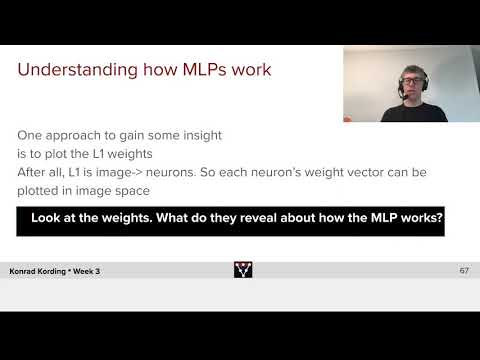

In [25]:
#@title Video 3.1: Map Receptive Fields
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="YcnImVQtaqc", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

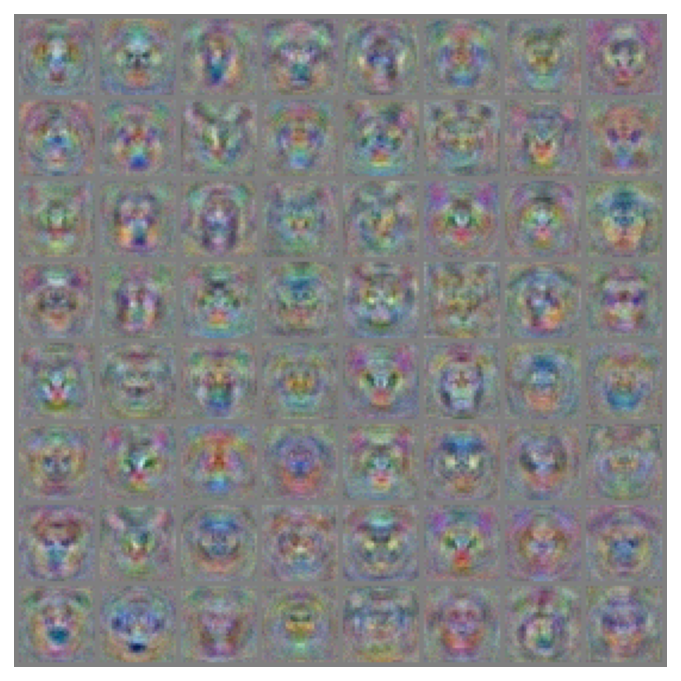

In [26]:
# visualize the feature map
fc1_weights = net.layers[0].weight.view(64, 3, 32, 32).detach().cpu()
fc1_weights /= torch.max(torch.abs(fc1_weights))
imshow(make_grid(fc1_weights, nrow=8))

In [27]:
#@markdown Even though it's three layers deep, we see distinct animal faces in the first layer feature map. Do you think this MLP has a hierarchical feature representation? why?
w3_isHierarchical = '' #@param {type:"string"}

---
# Section 4: The need for good initialization (optional)

Video available at https://youtu.be/C7NdUgg40YY


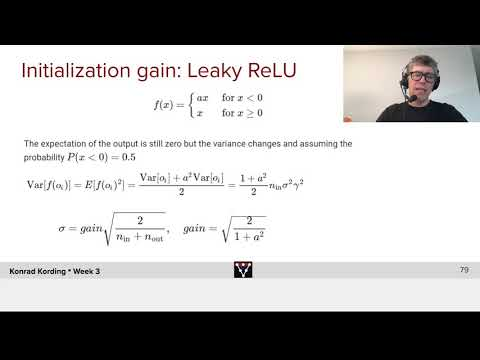

In [28]:
#@title Video 4: Initialization
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="C7NdUgg40YY", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## Xavier initialization
Let us look at the scale distribution of an output (e.g., a hidden variable)  $o_i$  for some fully-connected layer without nonlinearities. With  $n_{in}$  inputs  ($x_j$)  and their associated weights  $w_{ij}$  for this layer. Then an output is given by,
$$
o_{i} = \sum_{j=1}^{n_\mathrm{in}} w_{ij} x_j
$$
The weights  $w_{ij}$  are all drawn independently from the same distribution. Furthermore, let us assume that this distribution has zero mean and variance  $\sigma^2$ . Note that this does not mean that the distribution has to be Gaussian, just that the mean and variance need to exist. For now, let us assume that the inputs to the layer  $x_j$ also have zero mean and variance  $\gamma^2$  and that they are independent of $w_{ij}$ and independent of each other. In this case, we can compute the mean and variance of $o_i$ as follows:
\begin{split}\begin{aligned}
    E[o_i] & = \sum_{j=1}^{n_\mathrm{in}} E[w_{ij} x_j] = \sum_{j=1}^{n_\mathrm{in}} E[w_{ij}] E[x_j] = 0, \\
    \mathrm{Var}[o_i] & = E[o_i^2] - (E[o_i])^2 = \sum_{j=1}^{n_\mathrm{in}} E[w^2_{ij} x^2_j] - 0 = \sum_{j=1}^{n_\mathrm{in}} E[w^2_{ij}] E[x^2_j] = n_\mathrm{in} \sigma^2 \gamma^2
\end{aligned}\end{split}
One way to keep the variance fixed is to set $n_{in}\sigma^2=1$ . Now consider backpropagation. There we face a similar problem, albeit with gradients being propagated from the layers closer to the output. Using the same reasoning as for forward propagation, we see that the gradients’ variance can blow up unless $n_{out}\sigma^2=1$ , where  $n_{out}$ is the number of outputs of this layer. This leaves us in a dilemma: we cannot possibly satisfy both conditions simultaneously. Instead, we simply try to satisfy:
\begin{aligned}
\frac{1}{2} (n_\mathrm{in} + n_\mathrm{out}) \sigma^2 = 1 \text{ or equivalently }
\sigma = \sqrt{\frac{2}{n_\mathrm{in} + n_\mathrm{out}}}
\end{aligned}
This is the reasoning underlying the now-standard and practically beneficial Xavier initialization, named after the first author of its creators [Glorot & Bengio, 2010]. Typically, the Xavier initialization samples weights from a Gaussian distribution with zero mean and variance  $\sigma^2=\frac{2}{(n_{in}+n_{out})}$. We can also adapt Xavier’s intuition to choose the variance when sampling weights from a uniform distribution. Note that the uniform distribution $U(−a,a)$ has variance $\frac{a^2}{3}$. Plugging this into our condition on $\sigma^2$ yields the suggestion to initialize according to
$$
U\left(-\sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}, \sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}\right)
$$
This explanation is mainly taken from [here](https://d2l.ai/chapter_multilayer-perceptrons/numerical-stability-and-init.html).


## Initialization with transfer function
Let's derive the optimal gain for LeakyReLU following a similar steps,

$$
f(x)=\left\{\begin{array}{ll}
a x & \text { for } x<0 \\
x & \text { for } x \geq 0
\end{array}\right.
$$

Considering a single layer with activation gives, 


The expectation of the output is still zero but the variance changes and assuming the probability $P(x < 0) = 0.5$

\begin{split}\begin{aligned}
    \mathrm{Var}[f(o_i)] = E[f(o_i)^2] & = \frac{\mathrm{Var}[o_i] + a^2 \mathrm{Var}[o_i]}{2} = \frac{1+a^2}{2}n_\mathrm{in} \sigma^2 \gamma^2
\end{aligned}\end{split}

Therefore following the rest of derivation as before,

$$
\sigma = gain\sqrt{\frac{2}{n_\mathrm{in} + n_\mathrm{out}}}, \quad gain = \sqrt{\frac{2}{1+a^2}}
$$

## Exercise 4: Best gain for Xavier Initialization with Leaky ReLU
You're probably running out of time, so let me explain what's happening here. We derived a theoretical gain for initialization. But the question is whether it holds in practice? Here we have a setup to confirm our finding. We will try a range of gains and see the empirical optimum and whether it matches our theoretical value!

Accuracy on the 14630 training samples: 35.22 %
Accuracy on the 1500 testing samples: 33.33 %


Accuracy on the 14630 training samples: 49.32 %
Accuracy on the 1500 testing samples: 48.80 %


Accuracy on the 14630 training samples: 64.87 %
Accuracy on the 1500 testing samples: 63.80 %


Accuracy on the 14630 training samples: 71.50 %
Accuracy on the 1500 testing samples: 68.80 %


Accuracy on the 14630 training samples: 73.33 %
Accuracy on the 1500 testing samples: 72.60 %


Accuracy on the 14630 training samples: 70.80 %
Accuracy on the 1500 testing samples: 70.73 %


Accuracy on the 14630 training samples: 70.31 %
Accuracy on the 1500 testing samples: 68.47 %


Accuracy on the 14630 training samples: 69.10 %
Accuracy on the 1500 testing samples: 64.80 %


Accuracy on the 14630 training samples: 66.97 %
Accuracy on the 1500 testing samples: 65.20 %


Accuracy on the 14630 training samples: 66.95 %
Accuracy on the 1500 testing samples: 65.67 %


[]

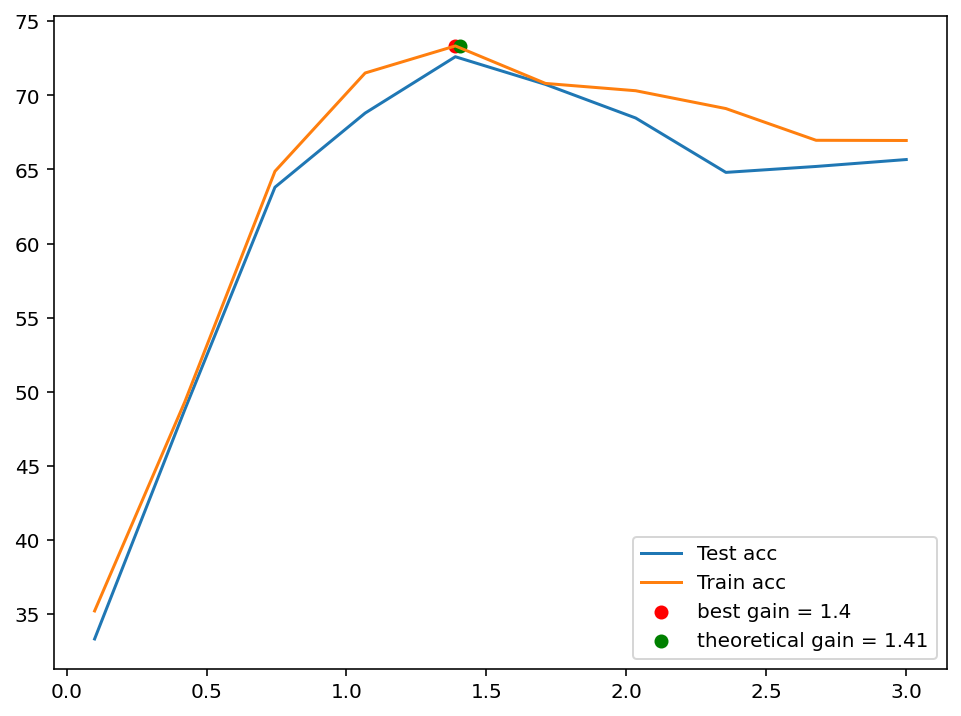

In [29]:
N = 10 # number of trials
gains = np.linspace(1/N, 3.0, N)
test_accs = []
train_accs = []
for gain in gains:

  def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight, gain)
        # torch.nn.init.xavier_uniform_(m.weight, gain)

  negative_slope = 0.1
  actv = 'LeakyReLU(%f)'%negative_slope
  net = Net(actv, 3*32*32, [128, 64, 32], 3).to(dev)
  net.apply(init_weights)
  criterion = nn.CrossEntropyLoss()

  optimizer = optim.SGD(net.parameters(), lr=1e-2)
  train_acc, test_acc = train_test_classification(net, criterion, optimizer,
                                                  img_train_loader, img_test_loader,
                                                  num_epochs=1, verbose=True)
  test_accs += [test_acc]
  train_accs += [train_acc]

best_gain = gains[np.argmax(train_accs)]
plt.plot(gains, test_accs, label='Test acc')
plt.plot(gains, train_accs, label='Train acc')
plt.scatter(best_gain, max(train_accs), label='best gain = %.1f'%best_gain, c='r')
theoretical_gain = np.sqrt(2.0 / (1 + negative_slope ** 2))
plt.scatter(theoretical_gain, max(train_accs), label='theoretical gain = %.2f'%theoretical_gain, c='g')
plt.legend()
plt.plot()

---
# Conclusion

Video available at https://youtu.be/Jzc9Ua0isYI


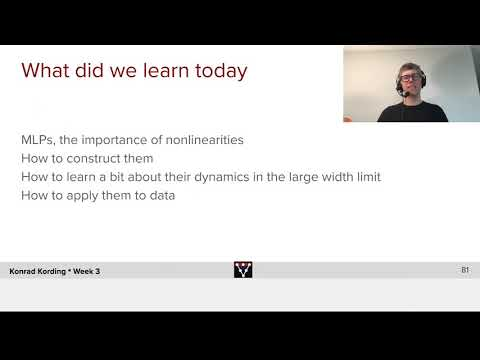

In [30]:
#@title Video 5: Wrapping Up Day 3
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="Jzc9Ua0isYI", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

# Submit your responses
Please run the following cell and then press "Submit" so we can record your responses.

In [31]:
import time
import numpy as np
from IPython.display import IFrame
#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**

def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefills = "&".join(["prefill_%s=%s"%(key, fields[key]) for key in fields])
  src = src + prefills
  src = "+".join(src.split(" "))
  return src


#autofill time if it is not present
try: t1;
except NameError: t1 = time.time()
try: t2;
except NameError: t2 = time.time()
try: t3;
except NameError: t3 = time.time()
try: t4;
except NameError: t4 = time.time()
try: t5;
except NameError: t5 = time.time()
try: t6;
except NameError: t6 = time.time()
try: t7;
except NameError: t7 = time.time()

#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""

try: my_pod;
except NameError: my_pod = "Select"

try: w3_with_non_linear_loss;
except NameError: w3_with_non_linear_loss = ""

try: w3_poly_OoD;
except NameError: w3_poly_OoD = ""

try: w3_why_three;
except NameError: w3_why_three = ""

try: w3_fast_NTK;
except NameError: w3_fast_NTK = ""

try: w3_isHierarchical;
except NameError: w3_isHierarchical = ""

try: w3_whichActiv;
except NameError: w3_whichActiv = ""

times = np.array([t2,t3,t4,t5,t6,t7])-t1

fields = {"pennkey": my_pennkey,
          "pod": my_pod,
          "w3_with_non_linear_loss":w3_with_non_linear_loss,
          "w3_poly_OoD": w3_poly_OoD,
          "w3_why_three":w3_why_three,
          "w3_fast_NTK": w3_fast_NTK,
          "w3_isHierarchical":w3_isHierarchical,
          "w3_whichActiv":w3_whichActiv,
          "cumulative_times": times}

src = "https://airtable.com/embed/shrElsLHM2gDYmFnl?"

#now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))

## Feedback
How could this session have been better? How happy are you in your group? How do you feel right now?

Feel free to use the embeded form below or use this link:
<a target="_blank" rel="noopener noreferrer" href="https://airtable.com/shrNSJ5ECXhNhsYss">https://airtable.com/shrNSJ5ECXhNhsYss</a>

In [32]:
display(IFrame(src="https://airtable.com/embed/shrNSJ5ECXhNhsYss?backgroundColor=red", width = 800, height = 400))

# Homeworks
* (1) Join the Kaggle Competition to solve Animal Faces with random permutations using MLPs.
* (2) Something where you debug something: Cross-entropy optimization with poor initialization, producing NaNs.
* (3) Something related to ethics: A classification system with interest bias?
* (4) Read some cool original paper:  Kernel vs Rich regimes paper?


# Kaggle competition
https://www.kaggle.com/c/permuted-animal-faces/